<a href="https://colab.research.google.com/github/HLCV-23/Inpainting-Detection/blob/main/project_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import os
import torch
from PIL import Image
import requests
!pip install transformers
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np
!pip install diffusers
!pip install accelerate
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import requests
import time
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch import cuda, bfloat16
import transformers
import torch
from transformers import StoppingCriteria, StoppingCriteriaList

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [ ]:
device = torch.device("cuda:0")

# count time
start_time = time.time()

print("LOADING MODEL")
print("time passed: "+str(time.time()-start_time))
print("\n")
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=device)


img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512,512))

#plt.imshow(raw_image)
#plt.show()

print("GENERATING MASKS")
print("time passed: "+str(time.time()-start_time))
print("\n")
outputs = generator(raw_image, points_per_batch=64)

print("SHOWING MASKS")
print("time passed: "+str(time.time()-start_time))
print("\n")
masks = outputs["masks"]
#show_masks_on_image(raw_image, masks)

LOADING MODEL
time passed: 0.00016951560974121094


GENERATING MASKS
time passed: 38.01274514198303


SHOWING MASKS
time passed: 47.538753271102905




In [ ]:
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

caption = image_to_text(raw_image)[0]["generated_text"]
print(caption)

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.8.crossattention.masked_bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.7.crossattention.masked_bias', 'decoder.transformer.h.4.crossattention.masked_bias', 'decoder.transformer.h.9.attn.bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transformer.h.11.crossattention.masked_bias', 'decoder.transformer.h.5.crossattention.bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.2.crossattention.masked_bias', 'decoder.transformer.h.2.attn.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.1.crossattention.masked_bias', 'decoder.transformer.h.9.crossattention.masked_bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.3.attn.masked_b

a blue car parked in front of a building 


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
model = AutoModelForCausalLM.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
gpt2_pipe = pipeline("text-generation", model= model, tokenizer = tokenizer, device = device)

prompt = gpt2_pipe(caption)[0]["generated_text"]

print(prompt)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a blue car parked in front of a building  with a sign in the rain, The sign reads::



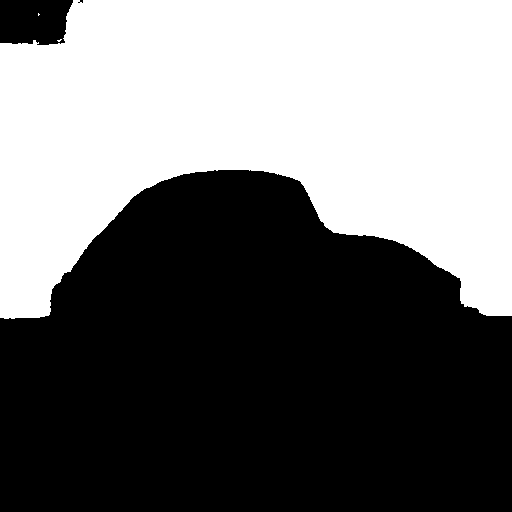

In [ ]:
mask_areas = []
for i in range(len(masks)):
  area = np.sum(masks[i])
  mask_areas.append(area)

min_area = np.mean(mask_areas)# - np.std(mask_areas)

while True:
  mask_id = np.random.choice(np.arange(len(masks)))

  area = np.sum(masks[mask_id])
  if area >= min_area:
    break

mask_img = Image.fromarray((masks[mask_id] * 255).astype(np.uint8).squeeze())
mask_img = mask_img.convert("RGB")
mask_img

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


(512, 512, 1)
(512, 512, 3)


  0%|          | 0/50 [00:00<?, ?it/s]

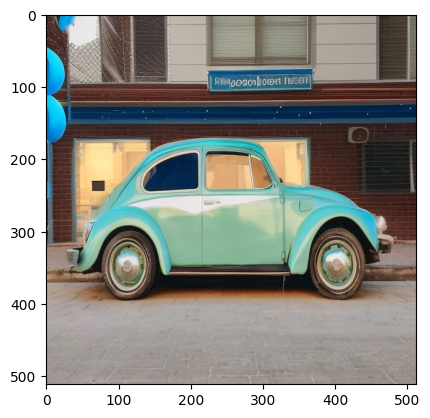

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    #"stabilityai/stable-diffusion-2-inpainting",
    "Uminosachi/dreamshaper_5-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe.to("cuda:0")

mask = masks[1]
mask = np.expand_dims(mask, axis=2)
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512,512))
print(mask.shape)
print(np.array(raw_image).shape)
image = pipe(prompt=prompt, image=raw_image, mask_image=mask_img,height=512,
    width=512).images[0]
plt.imshow(image)
plt.show()

# Dataset Generation

In [ ]:
# hugging face token is required to load dataset,
# go to https://huggingface.co/datasets/imagenet-1k/viewer/default/train
# and get a token in the account settings
! pip install datasets
! huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.4 MB/s eta 0:00:00

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tok

In [ ]:
# download imagenet
from datasets import load_dataset, Dataset, Image
import pandas as pd
import os

dataset = load_dataset("imagenet-1k", use_auth_token = True, streaming = True, split = "train")
dataset = iter(dataset.shuffle())
next(dataset)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x340 at 0x7F117B2CF730>,
 'label': 868}

In [ ]:
from PIL import Image, ImageFilter

def generate_datapoint(dataset, id, csv_data, batch_size = 8):
    data = [next(dataset)["image"].resize((512,512)) for _ in range(batch_size)]
    print(data)
    masks = generator(data)
    masks = [d["masks"] for d in masks]
    # get mask
    mask_img = [Image.fromarray((curr_mask[0] * 255).astype(np.uint8).squeeze()).convert("RGB") for curr_mask in masks]
    plt.imshow(mask_img[0])
    plt.show()

    caption = [txt[0]["generated_text"] for txt in image_to_text(data)]
    prompt = [txt[0]["generated_text"] for txt in gpt2_pipe(caption)]
    print(prompt)

    # inpaint
    inpainted_img = pipe(prompt=prompt, image=data, mask_image=mask_img, height=512, width=512).images
    plt.imshow(inpainted_img[0])
    plt.show()

    for i in range(batch_size):
      inpainted_img[i].save(f"Prototype-Dataset/Image/{id+i}.jpeg")
      # I think we need to save the binary masks as .npy tensors because jpeg compression could change the values but they need to be 0 or 1
      mask_img[i].save(f"Prototype-Dataset/Masks/{id+i}.jpeg")
      csv_data.at[id + i, "Prompt"] = prompt[i]


def generate_datapoint_no_batch(data, id, csv_data):
    data = data["image"].resize((512,512))
    data.show()
    masks = generator(data)["masks"]

    # compute areas of all masks
    mask_areas = []
    mask_ids = []
    for i in range(len(masks)):
      area = np.sum(masks[i])
      mask_areas.append(area)

    # define minimum size for masks
    min_area = np.mean(mask_areas) + np.std(mask_areas)

    # we combine 3 randomly sampled masks that fulfill the min area
    n = min(3, len(masks)-2)
    while len(mask_ids) <= n:
      mask_id = np.random.choice(np.arange(len(masks)))

      for id in mask_ids:
        if id == mask_id:
          continue

      area = np.sum(masks[mask_id])
      if area >= min_area:
        mask_ids.append(mask_id)

    # combine these masks into a single mask
    mask = masks[mask_ids[0]]
    for i in range(len(mask_ids)):
      mask_id = mask_ids[i]
      curr_mask = masks[mask_id]
      mask = np.logical_or(mask, curr_mask)

    mask_img = Image.fromarray((mask * 255).astype(np.uint8).squeeze())
    mask_img = mask_img.convert("RGB")
    #mask_img.show()

    caption = image_to_text(data)[0]["generated_text"]
    prompt = gpt2_pipe(caption)[0]["generated_text"]
    print(prompt)

    # inpaint
    inpainted_img = pipe(prompt=prompt, image=data, mask_image=mask_img, height=512, width=512).images[0]
    #inpainted_img.show()

    # get the edges of the mask
    edges = mask_img.filter(ImageFilter.FIND_EDGES).filter(ImageFilter.MaxFilter(7)).convert("1")
    #edges.show()

    # blur the inpainted image
    inpainted_img_blur = inpainted_img.filter(ImageFilter.GaussianBlur(radius = 1))
    #inpainted_img_blur.show()

    # add the blured parts along the borders of the inpainted object to make it smoother
    inpainted_img_smooth = Image.composite(inpainted_img_blur, inpainted_img, edges).convert("RGB")
    inpainted_img_smooth.show()

    inpainted_img_smooth.save(f"Prototype-Dataset/Images/{id}.jpeg")
    # I think we need to save the binary masks as .npy tensors because jpeg compression could change the values but they need to be 0 or 1
    mask_img.save(f"Prototype-Dataset/Masks/{id}.jpeg")
    csv_data.at[id, "Prompt"] = prompt

In [ ]:
next(dataset)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7F117B4A7790>,
 'label': 816}

In [ ]:
#"""
!mkdir Prototype-Dataset
!touch Prototype-Dataset/Prompts.csv
!mkdir Prototype-Dataset/Images
!mkdir Prototype-Dataset/Masks
!pwd
#"""

/content


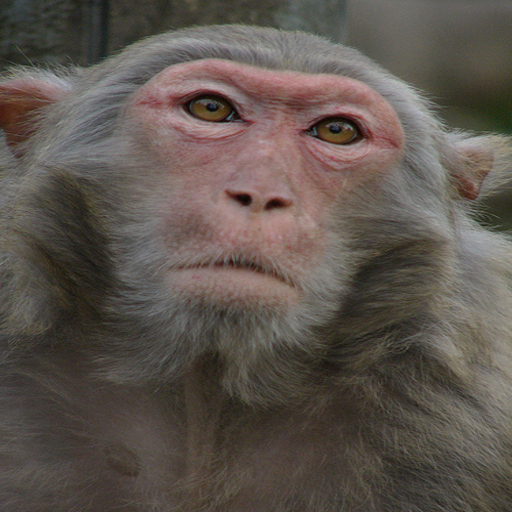

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a large black and white dog with a red face , concept art by James Gurney and Laurie Greasley, high detail, stylized, national geographic, blue tones



  0%|          | 0/50 [00:00<?, ?it/s]

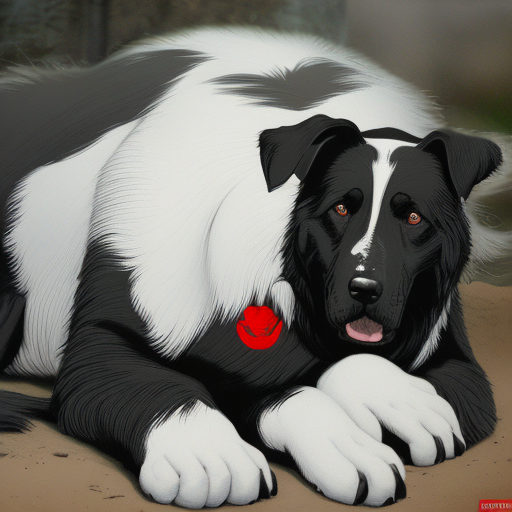

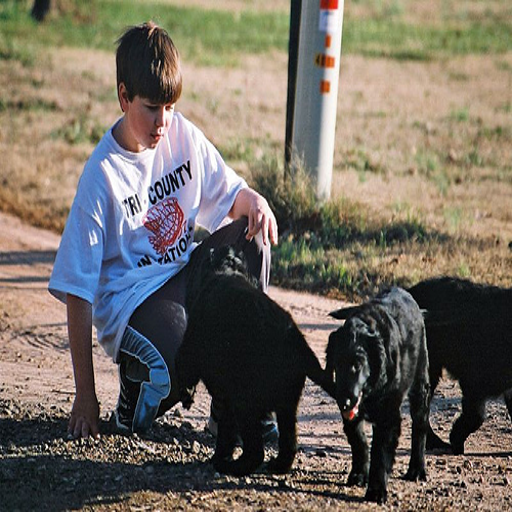

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a boy and a dog are playing with a dog  near the river on a summer day. By Makoto Shinkai, Stanley Artgerm Lau, WLOP, Rossdraws, James Jean, Andrei Riabovitchev,


  0%|          | 0/50 [00:00<?, ?it/s]

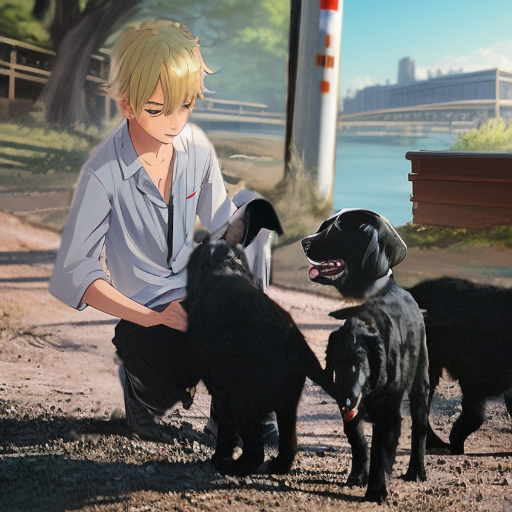

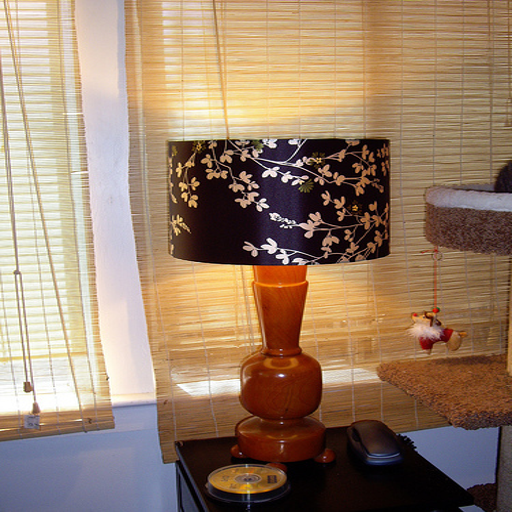

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a lamp is on in a room with a vase and a vase holder , concept art, octane render, unreal engine 5, trending on Artstation, high quality, 8K, soft lighting, trending on DeviantArt, highly


  0%|          | 0/50 [00:00<?, ?it/s]

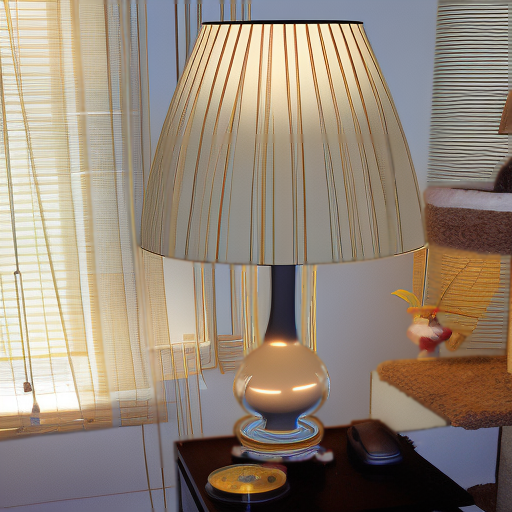

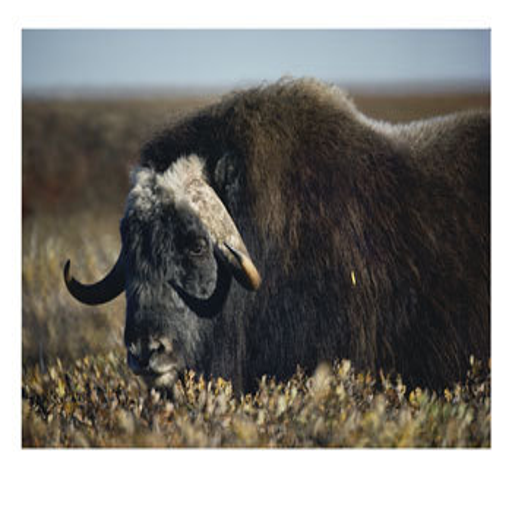

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a large brown bull standing next to a small brown bull  sitting on top of the red and orange colored bull's body, the sun is setting and the grass is cool, illustration, digital art, inspired by little big planet, by greg r


  0%|          | 0/50 [00:00<?, ?it/s]

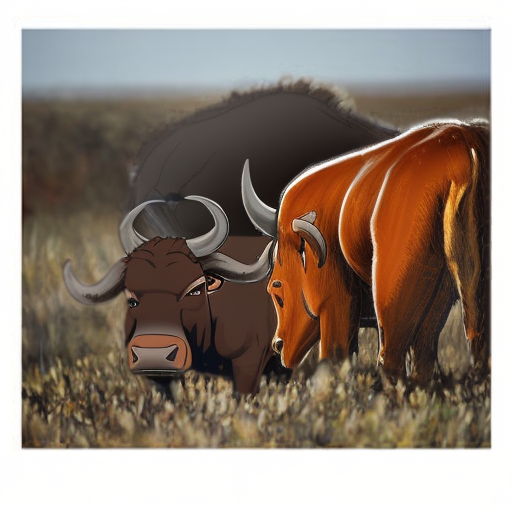

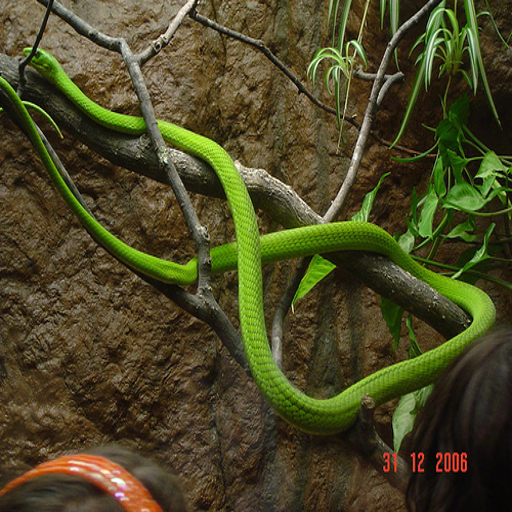

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a green and white striped and green plant next to a rock wall , autumn, pink and green leaves, volumetric lighting, digital painting, highly detailed, artstation, sharp focus, illustration, concept art, ruan jia, ste


  0%|          | 0/50 [00:00<?, ?it/s]

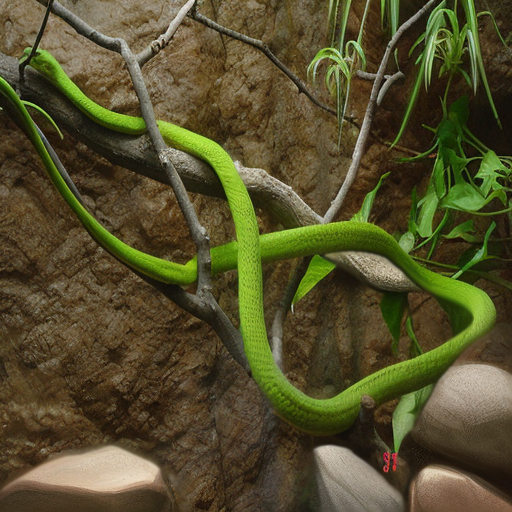

In [ ]:
"""
try:
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")
except:
  with open("Prototype-Dataset/Prompts.csv", "w+") as f:
    f.write("prompt")
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")

generate_datapoint_no_batch(next(dataset), 2, csv_data)
"""
try:
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")
except:
  with open("Prototype-Dataset/Prompts.csv", "w+") as f:
    f.write("prompt")
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")

for id in range(5):
    generate_datapoint_no_batch(next(dataset), id, csv_data)

csv_data.to_csv("Prototype-Dataset/Prompts.csv")

In [ ]:
try:
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")
except:
  with open("Prototype-Dataset/Prompts.csv", "w+") as f:
    f.write("prompt")
  csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")

generate_datapoint(dataset, 2, csv_data)

csv_data.to_csv("Prototype-Dataset/Prompts.csv")

In [ ]:
csv_data = pd.read_csv("Prototype-Dataset/Prompts.csv")
for id in range(100):
    img = next(dataset)["image"]
    generate_datapoint(img, id, csv_data)

csv_data.to_csv("Prototype-Dataset/Prompts.csv")

In [ ]:
image_paths = [f"Prototype-Dataset/Images/{f}" for f in os.listdir("Prototype-Dataset/Images/")]
mask_paths = [f"Prototype-Dataset/Masks/{f}" for f in os.listdir("Prototype-Dataset/Masks/")]
def create_dataset(image_paths, mask_paths):
  dataset = Dataset.from_dict({
      "image" : image_paths,
      "mask"  : mask_paths
  })
  dataset.cast_column("image", Image())
  dataset.cast_column("mask", Image())
  return dataset

dataset = create_dataset(image_paths, mask_paths)
dataset = iter(dataset)

In [ ]:
next(dataset)

{'image': 'Prototype-Dataset/Images/6.jpeg',
 'mask': 'Prototype-Dataset/Masks/6.jpeg'}